## PriorCVAE-GP model visualization

In [1]:
import os
import random
import yaml

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn

from priorCVAE.datasets import GPDataset
import priorCVAE.priors as priors
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples

import jax.config as config
config.update("jax_enable_x64", True)


In [2]:
output_dir = "../arc_outputs/gp/qmdxj3dh/"
n = 5000
n_samples_plot = 25

In [3]:
ls_list = jnp.linspace(0.1, 1, 5)

In [4]:
cfg_path = os.path.join(output_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]["value"]
conditional = cfg_data["conditional"]["value"]
dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
kernel = getattr(priors, cfg_data["data_generator"]["value"]["kernel"]["_target_"].split(".")[-1])

x0 = cfg_data["x0"]["value"]
x1 = cfg_data["x1"]["value"]
n_data = cfg_data["n_data"]["value"]

In [5]:
x = jnp.linspace(x0, x1, n_data)

In [6]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [7]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [8]:
kernel

priorCVAE.priors.kernels.Matern12

In [9]:
gp_dataset = GPDataset(kernel=kernel(), x=x, sample_lengthscale=False)

## Plot Covariance

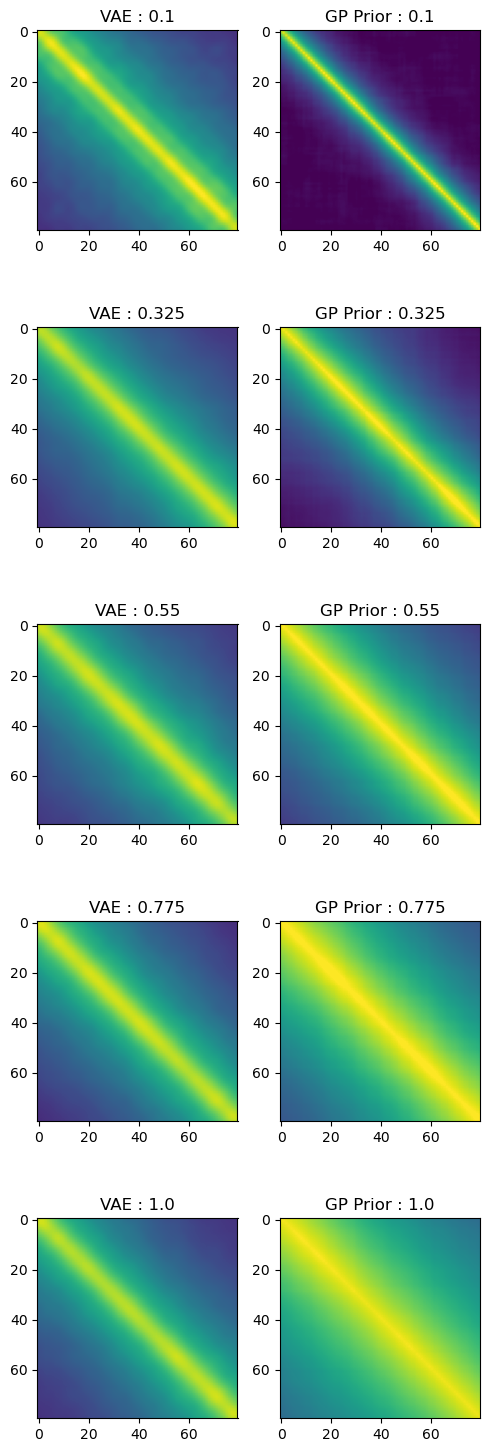

In [10]:
fig, axs = plt.subplots(ls_list.shape[0], 2, figsize=(5, 15))
for i, ls in enumerate(ls_list):
    rows = i
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = None
    if conditional:
        c = ls*jnp.ones((n, 1))
    
    gp_dataset.kernel.lengthscale = ls
    _, gp_samples, _ = gp_dataset.simulatedata(n)
    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    vae_cov = jnp.cov(vae_samples.T)
    gp_cov = jnp.cov(gp_samples.T)
    
    axs[rows][0].imshow(vae_cov, vmin=0, vmax=1)
    axs[rows][1].imshow(gp_cov, vmin=0, vmax=1)
    
    axs[rows][0].set_title(f"VAE : {ls}")
    axs[rows][1].set_title(f"GP Prior : {ls}")

plt.tight_layout()
plt.show()

## Plot Samples

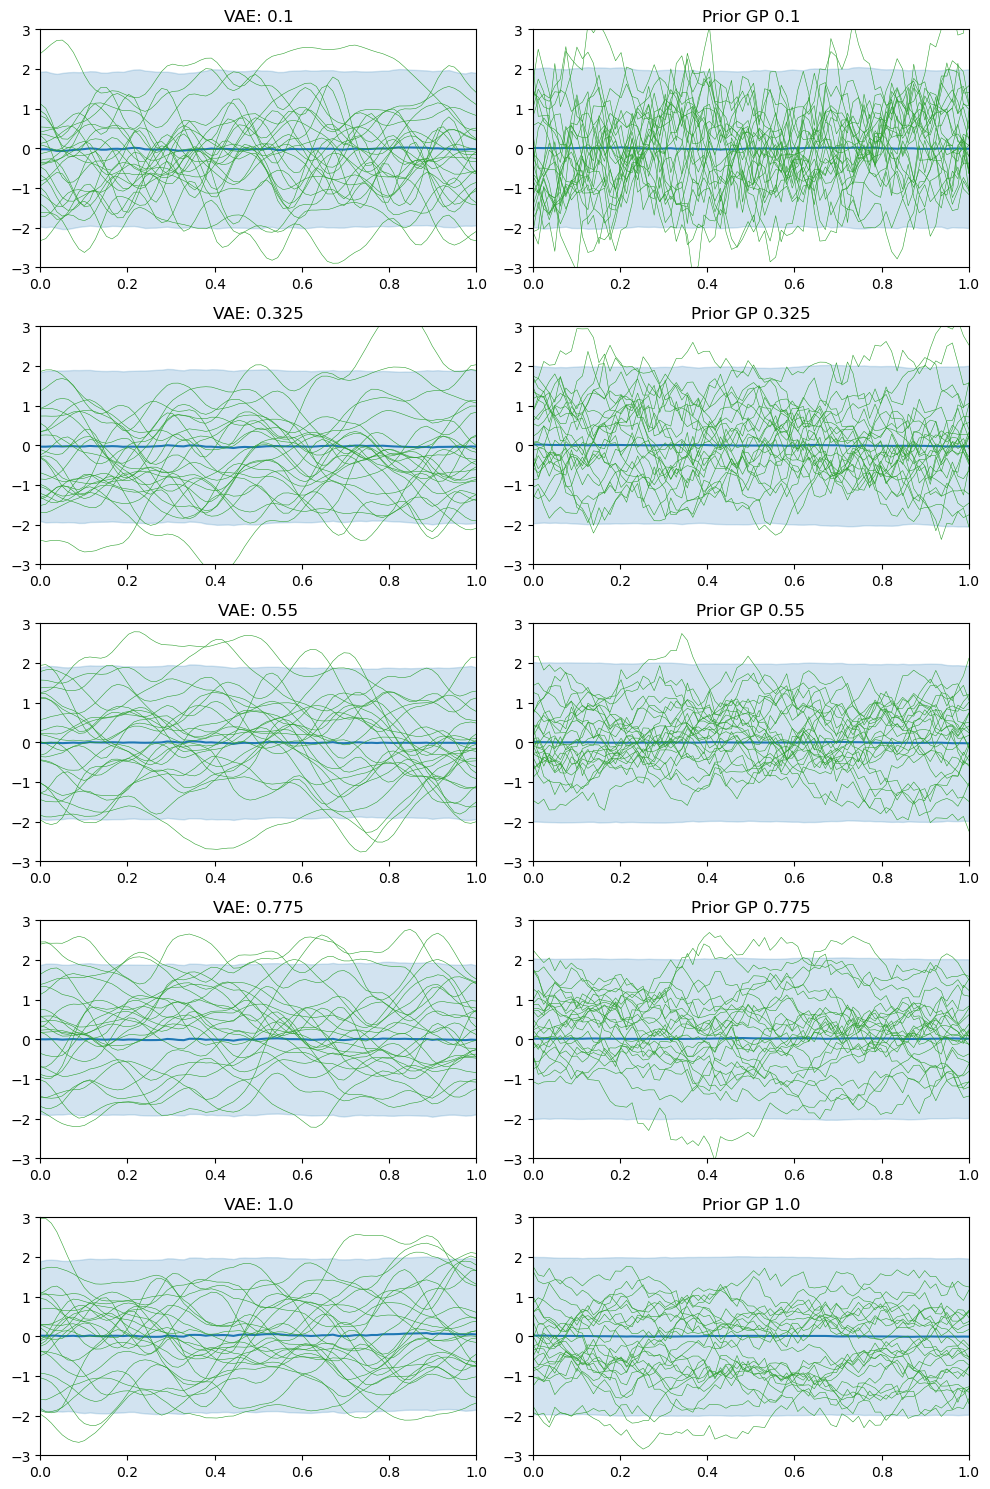

In [12]:
fig, axs = plt.subplots(ls_list.shape[0], 2, figsize=(10, 15))
for i, ls in enumerate(ls_list):
    
    rows = i
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = None
    if conditional:
        c = ls*jnp.ones((n, 1))
    
    gp_dataset.kernel.lengthscale = ls
    _, gp_samples, _ = gp_dataset.simulatedata(n)
    gp_samples_mean = jnp.mean(gp_samples, axis=0)
    gp_samples_std = jnp.std(gp_samples, axis=0)
    axs[rows][1].plot(x, gp_samples_mean, c="tab:blue")
    axs[rows][1].fill_between(x, gp_samples_mean - 2 * gp_samples_std, 
                                 gp_samples_mean + 2 * gp_samples_std, color="tab:blue", alpha=0.2)
    for v in gp_samples[:n_samples_plot]:
        axs[rows][1].plot(x, v, c="tab:green", linewidth=0.4)
    
    vae_samples = generate_decoder_samples(key, decoder_params=trained_decoder_params, decoder=decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    vae_samples_mean = jnp.mean(vae_samples, axis=0)
    vae_samples_std = jnp.std(vae_samples, axis=0)
    axs[rows][0].plot(x, vae_samples_mean, c="tab:blue")
    axs[rows][0].fill_between(x, vae_samples_mean - 2 * vae_samples_std, 
                                 vae_samples_mean + 2 * vae_samples_std, color="tab:blue", alpha=0.2)
    for v in vae_samples[:n_samples_plot]:
        axs[rows][0].plot(x, v, c="tab:green", linewidth=0.4)
    
    axs[rows][0].set_ylim([-3, 3])
    axs[rows][0].set_xlim([x[0], x[-1]])
    axs[rows][0].set_title(f"VAE: {ls}")
    
    
    axs[rows][1].set_ylim([-3, 3])
    axs[rows][1].set_xlim([x[0], x[-1]])
    axs[rows][1].set_title(f"Prior GP {ls}")

plt.tight_layout()
plt.show()